In [124]:
import torch
import torch.nn as NN
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

In [125]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [126]:
len(words)

32033

In [127]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [128]:
# building the dataset
block_size = 8 # Number of characters we take to make next prediction

def buildDataSet(words):
    X, Y = [], []
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [129]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = buildDataSet(words[:n1])
Xdev, Ydev = buildDataSet(words[n1:n2])
Xtest, Ytest = buildDataSet(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [130]:
vocabSize = len(stoi)

In [131]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [132]:
embdSize = 24 # the dimensionality of the character embedding vectors
hiddenNeurons = 128 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility


model = Sequential([
  NN.Embedding(vocabSize, embdSize),
  FlattenConsecutive(2), NN.Linear(embdSize * 2, hiddenNeurons, bias=False), BatchNorm1d(hiddenNeurons), NN.Tanh(),
  FlattenConsecutive(2), NN.Linear(hiddenNeurons*2, hiddenNeurons, bias=False), BatchNorm1d(hiddenNeurons), NN.Tanh(),
  FlattenConsecutive(2), NN.Linear(hiddenNeurons*2, hiddenNeurons, bias=False), BatchNorm1d(hiddenNeurons), NN.Tanh(),
  NN.Linear(hiddenNeurons, vocabSize),
])

# Parameters initialization
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # Make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [133]:
maxSteps = 200000
batchSize = 32
lossi = []

for i in range(maxSteps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batchSize,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{maxSteps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2699
  10000/ 200000: 2.0638
  20000/ 200000: 2.1357
  30000/ 200000: 2.0129
  40000/ 200000: 1.9926
  50000/ 200000: 1.8147
  60000/ 200000: 2.1647
  70000/ 200000: 2.0409
  80000/ 200000: 1.8778
  90000/ 200000: 2.0344
 100000/ 200000: 2.1430
 110000/ 200000: 2.1117
 120000/ 200000: 2.0247
 130000/ 200000: 1.7903
 140000/ 200000: 2.1029
 150000/ 200000: 1.9012
 160000/ 200000: 1.6889
 170000/ 200000: 1.6092
 180000/ 200000: 1.9333
 190000/ 200000: 1.7359


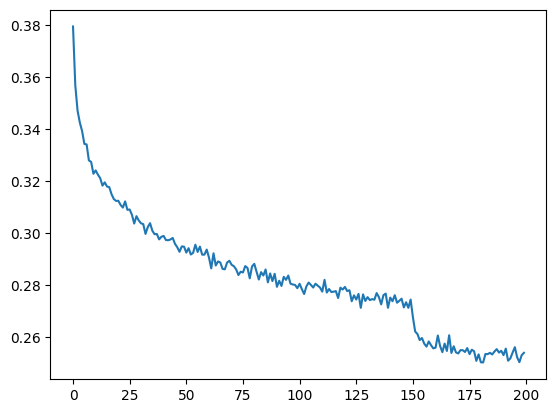

In [134]:
if len(lossi) >= 1000:
    plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
else:
    print(f"Insufficient data in lossi: {len(lossi)} elements.")
    plt.plot(torch.tensor(lossi))  # Plot as is


In [135]:
# Putting layers in evaluation mode due to use of batch normalization
for layer in model.layers: 
    layer.training = False

Loss

In [136]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xtest, Ytest),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
split_loss('train')
split_loss('val')

train 1.7672208547592163
val 1.989997386932373


## Sampling

In [137]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)

      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

saniyah.
addeline.
kimea.
eastyn.
mayus.
zahari.
muhams.
jabriel.
miamilin.
azuri.
gentriwn.
ashtin.
gajleri.
partavion.
rosey.
rowen.
addalynne.
malora.
ashwoh.
lijahna.
